## <center> Прогнозирование финансового состояния ОАО "Компания А" с помощью методов Machine Learning <center>

<p style='text-align: justify;'>Применение методов Machine Learning для анализа данных и выявления скрытых закономерностей требует достаточного количества наблюдаемых данных, поэтому анализ бухгалтерской отчетности по формам №1 и №2 будет производится по квартально за период 2016 – 2020 гг.</p>    

Применяемый метод прогнозирования – модель **ARIMA** (_Autoregressive Integrated Moving Avarege_) авторегрессионное интегрированное скользящее среднее. Модель ARIMA – один из наиболее распространённых методов анализа и прогнозирования временных рядов. Эта модель позволяет обработать данные временного ряда, чтобы лучше понять этот ряд или предсказать его развитие.

ARIMA использует три основных параметра (_p_, _d_, _q_), которые выражаются целыми числами. Вместе эти три параметра учитывают сезонность, тенденцию и шум в наборах данных:
+ **_p_** – порядок авторегрессии (AR), который позволяет добавить предыдущие значения временного ряда. Этот параметр можно проиллюстрировать утверждением «завтра, вероятно, будет тепло, если в последние три дня было тепло».
+ **_d_** – порядок интегрирования (т. е. порядок разностей исходного временного ряда). Он добавляет в модель понятия разности временных рядов (определяет количество прошлых временных точек, которые нужно вычесть из текущего значения). Этот параметр иллюстрирует такое утверждение: «завтра, вероятно, будет такая же температура, если разница в температуре за последние три дня была очень мала».
+ **_q_** – порядок скользящего среднего (MA), который позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок.

In [1]:
# Загрузка библиотек для анализа и манипуляций с данными
import pandas as pd
import numpy as np
import random as rnd

# Загрузка библиотек для визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузка статистических инструментов для анализа временных рядов
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Импортирование метрик качества для оценки построенной модели
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

Прогнозирование будем производить по данным отчета о прибылях и убытках и бухгалтерского баланса. Для корректной работы специализированной программной среды **Jupyter Notebook**, статьи формы №2 и №1 были закодированы следующим образом:

+ __f2__ – Отчет о прибылях и убытках (форма №2); f2_10 – форма №2, стр. 10 (выручка от реализации продукции); f2_full – форма №2, стр. 020+040+050 (полная себестоимость продукции) и т.д.;
+ __f1__ – Бухгалтерский баланс (форма №1); f1_190 – форма №1, стр. 190 (долгосрочные активы) и т.д.

In [2]:
# Загрузка и чтение данных
fso_data = pd.read_excel('financial_data.xlsx', sheet_name = 'data',
                         index_col = 'Quarter', parse_dates=['Quarter'])

# Отобразим первые 5 строк наших данных и убедимся что данные корректно загружены
fso_data.head()

,f2_10,f2_full,f2_60,f2_150,f2_210,f1_190,f1_290,f1_260,f1_270,f1_490,f1_590,f1_690,f1_700
Quarter,,,,,,,,,,,,,
2015-12-31,20720,18187,2533,1708,1541,49746,17066,0,1486,46202,15394,5216,66812
2016-03-31,22484,19303,3181,3005,2411,51527,19270,0,784,48613,15722,6462,70797
2016-06-30,28927,22905,6022,5858,4748,50623,23709,0,1569,53361,13358,7613,74332
2016-09-30,33899,26556,7343,6925,5626,50621,26416,0,4756,58987,11367,6683,77037
2016-12-31,35979,27911,8068,7580,6108,50593,26424,0,4314,64150,6211,6656,77017


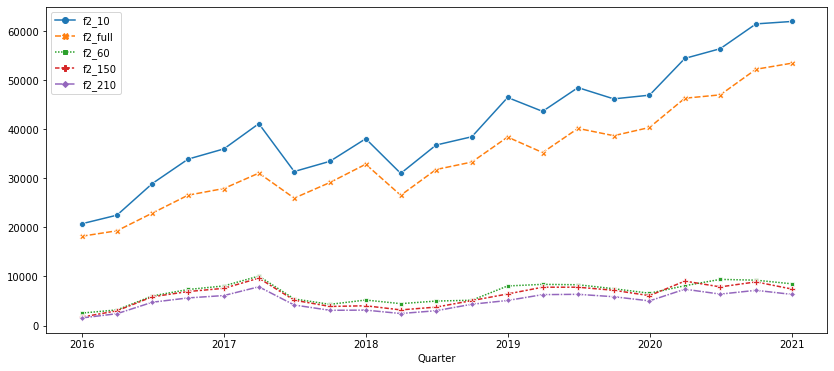

In [3]:
# Отобразим данные отчета о прибылях и убытках ОАО "Компания А" на диаграмме
f2_data = fso_data[['f2_10', 'f2_full', 'f2_60', 'f2_150','f2_210']]
plt.figure(figsize=(14,6))
lineplot1 = sns.lineplot(data=f2_data, markers=True)

Анализ диаграммы статей отчета о прибылях и убытках ОАО "Компания А" позволяет сделать следующие выводы:
+ выручка от реализации продукции в анализируемом периоде имеет тенденцию к росту, при этом наблюдается сезонность данного показателя;
+ полная себестоимость продукции увеличивается пропорционально росту выручки от реализации, соотношение затрат и выручки сохраняется на протяжении всего анализируемого периода;
+ прибыль от реализации продукции, прибыль до налогообложения и	чистая прибыль имеют положительную тенденцию к росту с увеличением выручки от реализации, прослеживается также сезонность данных показателей.

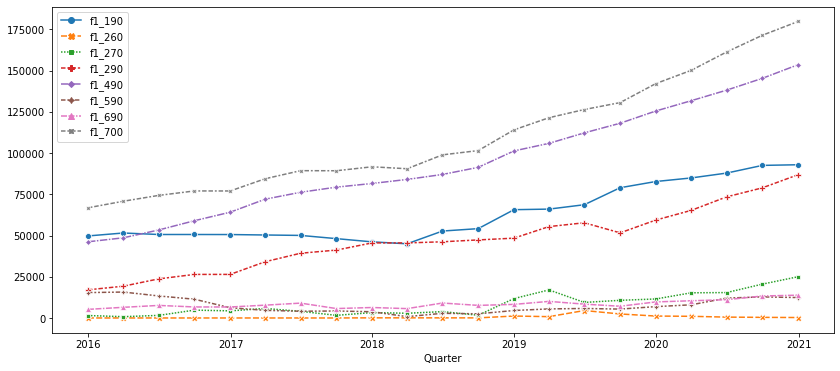

In [4]:
# Отобразим данные бухгалтерского баланса ОАО "Компания А" на диаграмме
f1_data = fso_data[['f1_190', 'f1_260', 'f1_270', 'f1_290',
                    'f1_490', 'f1_590', 'f1_690', 'f1_700']]
plt.figure(figsize=(14,6))
lineplot2 = sns.lineplot(data=f1_data, markers=True)

Анализ диаграммы статей бухгалтерского баланса ОАО "Компания А" позволяет сделать следующие выводы:
+ итог бухгалтерского баланса и собственный капитал в анализируемом периоде имеют тенденцию к росту, при этом тренд данных показателей имеет большую линейность и менее подвержен колебаниям в связи с сезонностью;
+ в период с 2016 г. по 2020 г. наблюдается уменьшение разрыва в соотношении между долгосрочными и краткосрочными активами предприятия;
+ долгосрочные и краткосрочные обязательства в анализируемом периоде практически не имеют тенденции к значительному увеличению;
+ с ростом активов баланса увеличивается количество денежных средств.

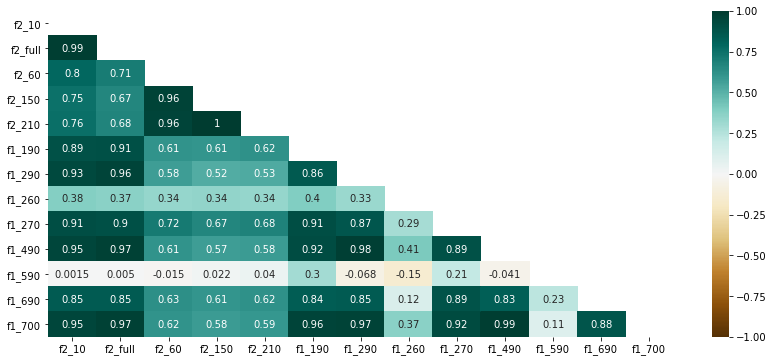

In [5]:
# Построим карту исследуемых признаков и посмотрим, есть ли между ними корреляция
plt.figure(figsize=(14, 6))
matrix = np.triu(fso_data.corr())
heatmap = sns.heatmap(fso_data.corr(), vmin=-1, vmax=1,
                      annot=True, cmap='BrBG', mask=matrix)

<p style='text-align: justify;'>Анализ карты корреляции признаков показывает, что между большим количеством статей формы №1 и №2 имеется достаточно высокая взаимозависимость.</p>

+ Наибольшая зависимость имеется между полной себестоимостью продукции и выручкой от реализации продукции;
+ Наименьшая зависимость от всех остальных показателей имеется у долгосрочных обязательств предприятия и краткосрочных финансовых вложений.

### 1 Прогнозирование статей отчета о прибылях и убытках ОАО "Компания А" на 2021 г.

In [6]:
# Разделим нашу выборку на обучающую и тестовую для обучения и оценки моделей
fso_data.copy()
train = fso_data[0:17]
test = fso_data[17:]

### 1.1 Подбор параметров для модели ARIMA вручную

<p style='text-align: justify;'>Главное в модели ARIMA – найти значения ARIMA (p, d, q), которые оптимизируют требуемый показатель. Для достижения этой цели можно подбирать параметры вручную анализируя графики автокорреляции (ACF) и частичной автокорреляции(PACF):</p>

+ **ACF** позволяет определить _**q**_, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели **MA**;
+ **PACF** позволяет определить _**p**_, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR;
+ параметр _**d**_ может принимать значение от 0 до 2. Обычно при построении модели ARIMA порядок разностей ограничивается числом d = 2. Это вызвано тем, что взятие вторых разностей обычно позволяет привести к стационарному виду практически любые нестационарные ряды данных.

<p style='text-align: justify;'>Для начала необходимо проверить временной ряд на стационарность и разложить его на компоненты и посмотреть присутствует ли сезонность в данных.</p>

### 1.2 Проверка временных рядов на стационарность

<p style='text-align: justify;'>Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как стационарность. Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями).</p>

<p style='text-align: justify;'>Стационарность важна т.к. по стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными.</p>

Проверка временного ряда на стационарность может ошуществлятся с помощью **теста Дики-Фуллера**. Это методика, которая используется в прикладной статистике и эконометрике для анализа временных рядов для проверки на стационарность.

In [7]:
# C помощью теста Дики-Фуллера проверим временной ряд "Выручка от реализации продукции"
# на стационарность
print("Dickey–Fuller test: p={:.3}".format(sm.tsa.stattools.adfuller(fso_data.f2_10)[1]))

Dickey–Fuller test: p=1.0


<p style='text-align: justify;'>Значение р = 1 (должно быть меньше 0,05) говорит о том, что временной ряд "Выручка от реализации продукции" не является стационарным.</p>

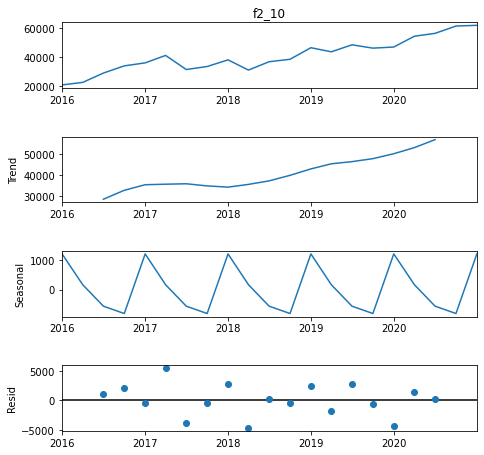

In [8]:
# Разложим показатель "Выручка от реализации продукции" на составляющие
decomposition_f2_10 = sm.tsa.seasonal_decompose(fso_data.f2_10, model='additive')
decomposition_f2_10.plot().set_size_inches(7, 7)

<p style='text-align: justify;'>Разложение на составляющие показателя "Выручка от реализации продукции" показывает, что в анализируемом периоде у этого показателя имеется четко прослеживаемая сезонность, тренд является практически линейным и сохраняет положительный наклон.</p>

<p style='text-align: justify;'>Итак, предварительный анализ закончен, и для того чтобы определить компоненты модели вручную необходимо приводить временной ряд к стационарности с последующим построением графиков автокорреляции.</p>

In [9]:
# Преобразуем временной ряд с помощью логарифмирования и посмотрим
# на результат теста Дики-Фуллера
f2_10_log = np.log(fso_data.f2_10)
print("Dickey–Fuller test: p={:.3}".format(sm.tsa.stattools.adfuller(f2_10_log)[1]))

Dickey–Fuller test: p=0.999


<p style='text-align: justify;'>Преобразованный с помощью логорифрмирования временной ряд "Выручка от реализации продукции" все еще не является стационарным (р = 0,999). Для получения стационарности используем метод дифференцирования с логарифмически преобразованными данными и экспоненциально взвешенную скользящую среднюю с параметром ‘halflife = 1’. Этот параметр определяет величину экспоненциального затухания.</p>

In [10]:
# Расчитаем экспоненциально взвешенную скользящую среднюю и вычтем
# из нее логорифм временного ряда
df_log_weighted_avg = f2_10_log.ewm(halflife = 1).mean()
df_log_weighted_avg_diff = f2_10_log - df_log_weighted_avg
print("Dickey–Fuller test: p={:.3}".format(sm.tsa.stattools.adfuller(df_log_weighted_avg_diff)[1]))

Dickey–Fuller test: p=0.00199


<p style='text-align: justify;'>Значение р = 0.0019 (меньше 0,05) говорит о том, что преобразованный временной ряд "Выручка от реализации продукции" является стационарным. Теперь можно построить графики автокорреляции и проанализировать их.</p>

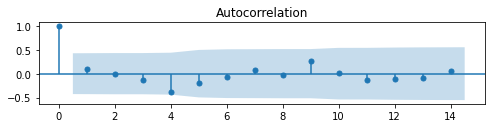

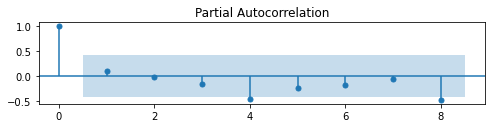

In [11]:
# Построим графики автокорреляции стационарного ряда
# "Выручка от реализации продукции"
plot_acf(df_log_weighted_avg_diff).set_size_inches(8, 1.5)
part_atc = plot_pacf(df_log_weighted_avg_diff, lags=8).set_size_inches(8, 1.5)

<p style='text-align: justify;'>Из графика PACF (Partial Autocorrelation) видно, что имеется выброс на 4, т.е. лаг сезонности равен 4. На графике ACF (Autocorrelation) существенных выбросов не имеется (все отклонения в допустимом интервале, обозначенном светло-синей заливкой). Таким образом:</p>

+ **_p_** – порядок авторегрессии (AR) будет равен нулю;
+ **_d_** – порядок интегрирования (т. е. порядок разностей исходного временного ряда) будет равен 1;.
+ **_q_** – порядок скользящего среднего (MA) также будет равен нулю.

Поскольку у нас имеется сезонность в данных, необходимо делать прогноз с помощью сезонной модели ARIMA (SARIMA). Общий вид данной модели **ARIMA(p,d,q)(P,D,Q)s**. Параметры обозначают следующее:
+ ___p___ — порядок (p)
+ ***d*** — порядок интегрирования исходных данных
+ ***q*** — порядок модели (q)
+ ***P*** — порядок сезонной составляющей (P)
+ ***D*** — порядок интегрирования сезонной составляющей
+ ***Q*** — порядок сезонной составляющей SMA(Q)
+ ***s*** — размерность сезонности (месяц, квартал и т.д.).

### 1.3 Подбор параметров для модели ARIMA автоматическим способом

Поскольку графики автокорреляции могут дать лишь общее представление о параметрах модели SARIMA, значения **(p,d,q)(P,D,Q)s** лучше подбирать с помощью автоматического последовательного перебора в заданных значениях, т.е. различные комбинации значений (p,d,q)(P,D,Q)s подставляются в модель SARIMA и рассчитывается наименьшее значение AIC.

<p style='text-align: justify;'>AIC расшифровывается как информационный критерий Акайке. Это метрика, которая помогает оценить качество модели. Чем ниже это значение, тем лучше работает модель.</p>

#### Алгоритм автоматического подбора параметров для модели SARIMA

In [12]:
from itertools import product

# Создание параметров для подстановки в модель
Qs = range(0, 3)
qs = range(0, 4)
Ps = range(0, 3)
ps = range(0, 4)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Выбор наилучшей модели SARIMA с наименьшим значением AIC
results = []
best_aic = float("inf")

for param in parameters_list:
    try:
        model=SARIMAX(fso_data.f2_10, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D,
                                                        param[3], 4)).fit(disp=-1)
    except:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [13]:
# Вывод результатов наилучших параметров для подстановки в модель SARIMA
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               f2_10   No. Observations:                   21
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 4)   Log Likelihood                -160.985
Date:                             Fri, 07 May 2021   AIC                            325.970
Time:                                     21:31:43   BIC                            327.515
Sample:                                 12-31-2015   HQIC                           326.049
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L4       -0.9896      0.422     -2.344      0.019      -1.817      -0.162
sigma2      2.536e+07   1.6

<p style='text-align: justify;'>Анализ результатов автоматического подбора показывает, что наилучшими параметрами для модели SARIMA при прогнозировании выручки от реализации продукции будет комбинация (0,1,0)х(0,1,1,4). При этом все коэффициенты модели являются статистически значимыми:</p>

+ ma.S.L4 (скользящая средняя с запаздыванием 4) = 0.019 < 0.05
+ sigma2 (дисперсия ошибки) = 0.000 < 0.05

In [14]:
# Подставим наилучшие значения параметров в модель и
# спрогнозируем выручку от реализации продукции
arima_f2_10 = SARIMAX(fso_data.f2_10, order=(0, 1, 0), seasonal_order=(0, 1, 1, 4)).fit()
f2_10_results = arima_f2_10.predict(start = 1, end = 24)
f2_10_pred = arima_f2_10.predict(start = 21, end = 24, typ="levels")

# Выведем результы прогноза выручки от реализации продукции
# ОАО "Компания А" на 2021 г. по кварталам
f2_10_pred

2021-03-31    62695.081507
2021-06-30    64253.337207
2021-09-30    66183.451952
2021-12-31    71359.351367
Freq: Q-DEC, Name: predicted_mean, dtype: float64

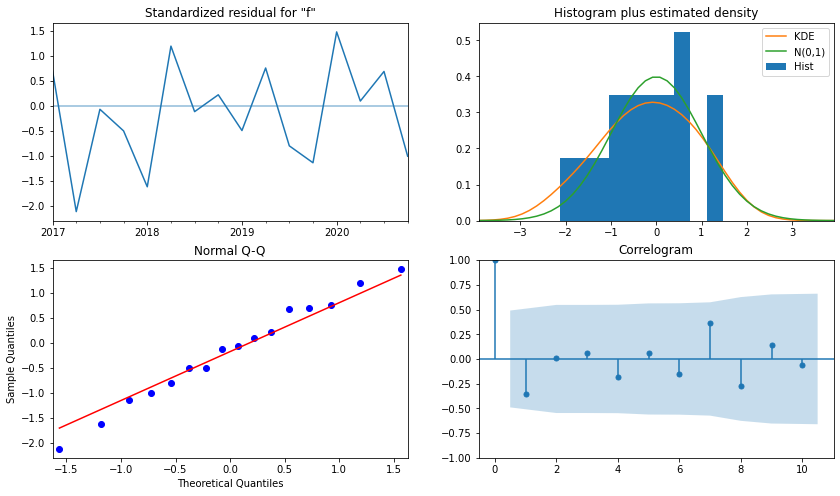

In [15]:
# Выведем результы статистической проверки построенной модели
arima_f2_10.plot_diagnostics(figsize=(14, 8))
plt.show()

<p style='text-align: justify;'>Анализ графиков показывает, что построенная модель корректна – остатки образуют случайный шум, между ними нет зависимости, а их распределение очень близко к нормальному распределению. Таким образом, полученные значения прогноза являются достоверными.</p>

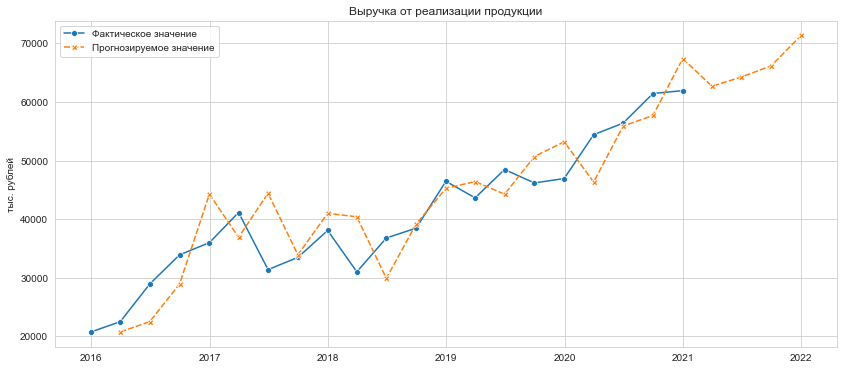

In [16]:
# Отобразим результаты прогнозирования выручки от реализации продукции на графике
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')
sns.lineplot(data=[fso_data.f2_10, f2_10_results], markers=True)
plt.legend(['Фактическое значение','Прогнозируемое значение']); plt.title('Выручка от реализации продукции')
plt.ylabel('тыс. рублей'); plt.savefig('arima_f2_10.png', dpi=600, bbox_inches='tight')
plt.show()

<p style='text-align: justify;'>Повторим последовательно все шаги при прогнозировании прибыли от реализации продукции и прибыли до налогообложения на 2021 г. Результаты автоматического подбора параметров и проверку на статистическую значимость модели повторять для каждого шага не будем, чтобы существенно не увеличивать объем приложения.</p>
    
<p style='text-align: justify;'>Поскольку у нас практически функциональная зависимость между выручкой от реализации продукции и полной себестоимостью продукции (корреляция составляет 99 %, т.е. сохраняется полная взаимозависимость), прогнозирование целесообразно проводить для прибыли от реализации продукции. Значение полной себестоимости продукции и чистой прибыли получим из следующих уравнений:</p>

**Полная себестоимость = Выручка от реализации продукции – Прибыль от реализации продукции**

**Чистая прибыль = Прибыль до налогообложения х 0,18 – Прибыль до налогообложения х 0,03 (прочие платежи, исчисляемые из прибыли)**

In [17]:
# Подставим наилучшие параметры для модели (3, 1, 3)х(0, 1, 1, 4),
# полученные автомотическим подбором и спрогнозируем прибыль от реализации продукции на 2021 г.
arima_f2_60 = SARIMAX(fso_data.f2_60, order=(3, 1, 3), seasonal_order=(0, 1, 1, 4)).fit()
f2_60_results = arima_f2_60.predict(start = 1, end = 24)
f2_60_pred = arima_f2_60.predict(start = 21, end = 24, typ="levels")

# Выведем результы прогноза прибыли от реализации продукции
# ОАО "Компания А" на 2021 г. по кварталам
f2_60_pred

2021-03-31     9225.400443
2021-06-30     9307.404934
2021-09-30     9262.364014
2021-12-31    10111.596279
Freq: Q-DEC, Name: predicted_mean, dtype: float64

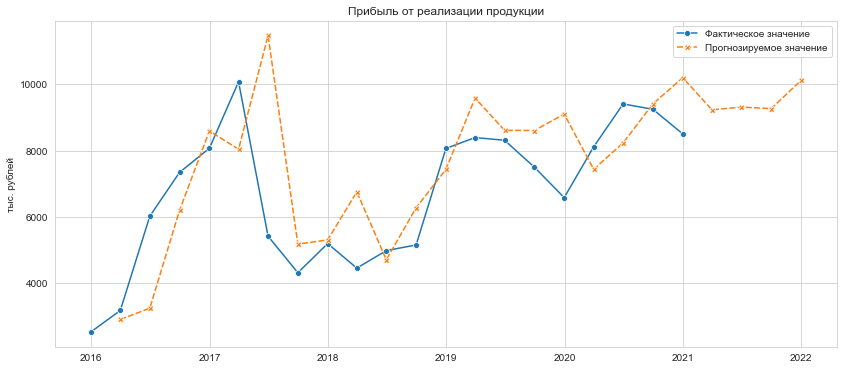

In [18]:
# Отобразим результаты прогнозирования прибыли от реализации продукции на графике
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')
sns.lineplot(data=[fso_data.f2_60, f2_60_results], markers=True)
plt.legend(['Фактическое значение','Прогнозируемое значение']); plt.title('Прибыль от реализации продукции')
plt.ylabel('тыс. рублей'); plt.show()

In [19]:
# Подставим наилучшие параметры для модели (0, 1, 0)x(1, 1, 0, 4),
# полученные автомотическим подбором и спрогнозируем прибыль до налогообложения на 2021 г.
arima_f2_150 = SARIMAX(fso_data.f2_150, order=(0, 1, 0), seasonal_order=(1, 1, 0, 4)).fit()
f2_150_results = arima_f2_150.predict(start = 1, end = 24)
f2_150_pred = arima_f2_150.predict(start = 21, end = 24, typ="levels")

# Выведем результы прогноза прибыли до налогообложения
# ОАО "Компания А" на 2021 г. по кварталам
f2_150_pred

2021-03-31    9345.307284
2021-06-30    8948.764088
2021-09-30    8876.842913
2021-12-31    7660.163100
Freq: Q-DEC, Name: predicted_mean, dtype: float64

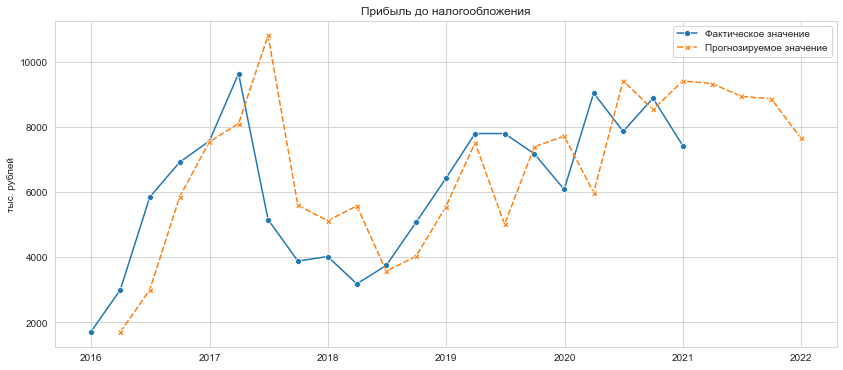

In [20]:
# Отобразим результаты прогнозирования прибыли до налогообложения на графике
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')
sns.lineplot(data=[fso_data.f2_150, f2_150_results], markers=True)
plt.legend(['Фактическое значение','Прогнозируемое значение'])
plt.title('Прибыль до налогообложения'); plt.ylabel('тыс. рублей')
plt.savefig('arima_f2_150.png', dpi=600, bbox_inches='tight'); plt.show()

In [21]:
# Получим значения полной себестоимости и чистой прибыли ОАО Компания А на 2021 г.
f2_full = round(f2_10_pred.sum() - f2_60_pred.sum())
f2_210 = round(f2_150_pred.sum() - ((f2_150_pred.sum() * 0.18) - (f2_150_pred.sum()*0.03)))
print('Полная себестоимость продукции = {} тыс. руб.'.format(f2_full),
      '\nЧистая прибыль = {} тыс. руб.'.format(f2_210))

Полная себестоимость продукции = 226584 тыс. руб. 
Чистая прибыль = 29606 тыс. руб.


In [22]:
# Сведем значения прогноза на 2021 г. по "Выручка от реализации продукции",
# "Полная себестоимость продукции", "Прибыль от реализации продукции",
# "Прибыль до налогообложения" и "Чистая прибыль" в одну таблицу 
f2_full_pred = f2_10_pred - f2_60_pred
f2_210_pred = f2_150_pred - (f2_150_pred * 0.18 - f2_150_pred * 0.03)

pred1 = pd.DataFrame({"Выручка":[round(value) for value in f2_10_pred],
                      "Полная себестоимость":[round(value) for value in f2_full_pred],
                      "Прибыль от реализации":[round(value) for value in f2_60_pred],
                      "Прибыль до налогообложения":[round(value) for value in f2_150_pred],
                     "Чистая прибыль":[round(value) for value in f2_210_pred]},
                     index = ['1й квартал','2й квартал','3й квартал', '4й квартал'])

pred1.loc["Итого 2021 г."] = [round(f2_10_pred.sum()), round(f2_full_pred.sum()),
                              round(f2_60_pred.sum()),
                              round(f2_150_pred.sum()), round(f2_210_pred.sum())]
pred1.to_excel('pred1.xlsx'); pred1

,Выручка,Полная себестоимость,Прибыль от реализации,Прибыль до налогообложения,Чистая прибыль
1й квартал,62695,53470,9225,9345,7944
2й квартал,64253,54946,9307,8949,7606
3й квартал,66183,56921,9262,8877,7545
4й квартал,71359,61248,10112,7660,6511
Итого 2021 г.,264491,226584,37907,34831,29606


In [23]:
# Оценим качество моделей посчитав среднюю абсолютную ошибку по прогнозируемым показателям,
# сравнив их с фактическим значением
mae_10 = f2_10_results[:20]; mae_60 = f2_60_results[:20]; mae_150 = f2_150_results[:20]

arima_mae_f2 = pd.DataFrame({"Выручка": round(mean_absolute_error(fso_data.f2_10[1:], mae_10)),
                          "Прибыль от реализации": round(mean_absolute_error(fso_data.f2_60[1:], mae_60)),
                        "Прибыль до налогообложения": round(mean_absolute_error(fso_data.f2_150[1:], mae_150))},
                         index = ['MAE'])

arima_mae_f2.to_excel('arima_mae_f2.xlsx'); arima_mae_f2

,Выручка,Прибыль от реализации,Прибыль до налогообложения
MAE,4796,1345,1581


<p style='text-align: justify;'>Таким образом, модель SARIMA ошибается в среднем на 4 796 тыс. рублей при прогнозировании выручки от реализации продукции, на 1 345 тыс. рублей при прогнозировании прибыли от реализации продукции и на 1 581 тыс. рублей при прогнозировании прибыли до налогообложения.

### 2 Прогнозирование статей бухгалтерского баланса ОАО "Компания А" на 2021 г.

<p style='text-align: justify;'>Поскольку у нас имеется практически функциональная зависимость между итогом баланса и долгосрочными активами (корреляция составляет 96 %, т.е. сохраняется практически полная взаимозависимость), прогнозирование целесообразно проводить для краткосрочных активов. Значение долгосрочных активов получим из следующего уравнения:</p>

**Долгосрочные активы = Итог баланса – Краткосрочные активы**

<p style='text-align: justify;'>Для расчета коэффициентов финансовой устойчивости предприятия, спрогнозируем также значения краткосрочных финансовых вложений и денежных средств и их эквивалентов на 31.12.2021 г.

Поскольку анализ диаграммы статей бухгалтерского баланса не позволяет однозначно дать ответ имеется ли в данных показателях сезонность, разложим прогнозируемые показатели на составляющие.</p>

### 2.1 Проверка статей бухгалтерского баланса на наличие сезонной компоненты

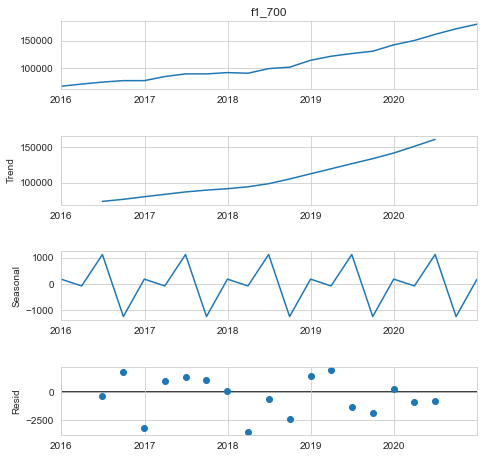

In [24]:
# Разложим показатель "Итог баланса" на составляющие
decomposition_f1_700 = sm.tsa.seasonal_decompose(fso_data.f1_700, model='additive')
decomposition_f1_700.plot().set_size_inches(7, 7)

<p style='text-align: justify;'>Разложение на составляющие показателя "Итог баланса" показывает, что в анализируемом периоде у этого показателя также имеются колебания сезонности, при этом тренд является практически линейным и сохраняет положительный наклон.</p>

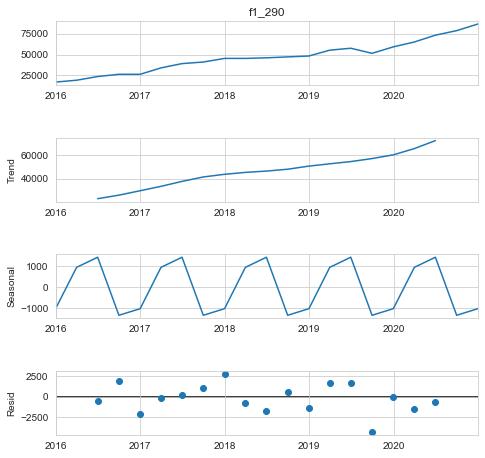

In [25]:
# Разложим показатель "Краткосрочные активы" на составляющие
decomposition_f1_290 = sm.tsa.seasonal_decompose(fso_data.f1_290, model='additive')
decomposition_f1_290.plot().set_size_inches(7, 7)

<p style='text-align: justify;'>Разложение на составляющие показателя "Краткосрочные активы" показывает, что в анализируемом периоде у этого показателя также имеются колебания сезонности, при этом тренд является практически линейным и сохраняет положительный наклон. Следовательно, для прогнозирования статей бух. баланса также необходимо применять модель SARIMA.</p>

<p style='text-align: justify;'>Повторим последовательно все шаги при прогнозировании "Итог баланса", "Краткосрочные активы", "Краткосрочные финансовые вложения", "Денежные средства и их эквиваленты" описанные в пункте 1.3. Результаты автоматического подбора параметров и проверку на статистическую значимость модели повторять для каждого шага не будем, чтобы существенно не увеличивать объем приложения.</p>


### 2.2 Прогнозирование статей бухгалтерского баланса

In [26]:
# Подставим наилучшие параметры для модели (2, 1, 2)x(2, 0, 0, 4),
# полученные автомотическим подбором и спрогнозируем итог баланса на 2021 г.
arima_f1_700 = SARIMAX(fso_data.f1_700, order=(2, 1, 2), seasonal_order=(2, 0, 0, 4)).fit()
f1_700_results = arima_f1_700.predict(start = 1, end = 24)
f1_700_pred = arima_f1_700.predict(start = 21, end = 24, typ="levels")

# Выведем результы прогноза итога баланса ОАО "Компания А" на 2021 г. по кварталам
f1_700_pred

2021-03-31    183356.589193
2021-06-30    190975.127517
2021-09-30    194627.641307
2021-12-31    201805.071153
Freq: Q-DEC, Name: predicted_mean, dtype: float64

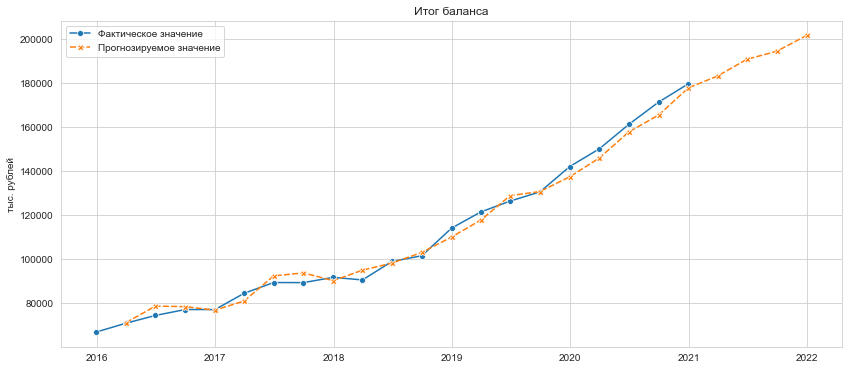

In [27]:
# Отобразим результаты прогнозирования итога баланса на графике
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')
sns.lineplot(data=[fso_data.f1_700, f1_700_results], markers=True)
plt.legend(['Фактическое значение','Прогнозируемое значение'])
plt.title('Итог баланса'); plt.ylabel('тыс. рублей')
plt.savefig('arima_f1_700.png', dpi=600, bbox_inches='tight'); plt.show()

In [28]:
# Подставим наилучшие параметры для модели (0, 1, 0)x(0, 1, 1, 4),
# полученные автомотическим подбором и спрогнозируем краткосрочные активы на 2021 г.
arima_f1_290 = SARIMAX(fso_data.f1_290, order=(0, 1, 0), seasonal_order=(0, 1, 1, 4)).fit()
f1_290_results = arima_f1_290.predict(start = 1, end = 24)
f1_290_pred = arima_f1_290.predict(start = 21, end = 24, typ="levels")

# Выведем результы прогноза краткосрочных активов 
# ОАО "Компания А" на 2021 г. по кварталам
f1_290_pred

2021-03-31     90729.353658
2021-06-30     94233.291166
2021-09-30     95095.785025
2021-12-31    100493.343054
Freq: Q-DEC, Name: predicted_mean, dtype: float64

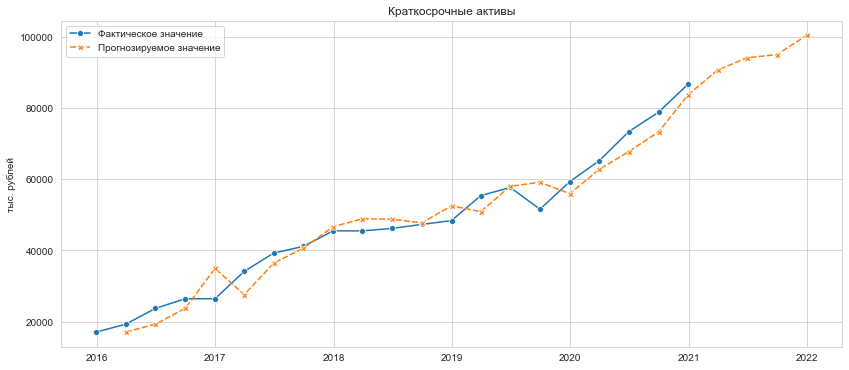

In [29]:
# Отобразим результаты прогнозирования краткосрочных активов на графике
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')
sns.lineplot(data=[fso_data.f1_290, f1_290_results], markers=True)
plt.legend(['Фактическое значение','Прогнозируемое значение'])
plt.title('Краткосрочные активы'); plt.ylabel('тыс. рублей')
plt.savefig('arima_f1_290.png', dpi=600, bbox_inches='tight'); plt.show()

In [30]:
# Подставим наилучшие параметры для модели (1, 1, 0)x(0, 0, 0, 4),
# полученные автомотическим подбором и спрогнозируем краткосрочные финансовые вложения на 2021 г.
arima_f1_260 = SARIMAX(fso_data.f1_260[8:], order=(1, 1, 0), seasonal_order=(0, 0, 0, 4)).fit()
f1_260_results = arima_f1_260.predict(start = 0, end = 12)
f1_260_pred = arima_f1_260.predict(start = 13, end = 16)

# Выведем результы прогноза краткосрочных финансовых вложений
# ОАО "Компания А" на 2021 г. по кварталам
f1_260_pred

2021-03-31    300.289721
2021-06-30    290.724344
2021-09-30    293.557953
2021-12-31    292.718536
Freq: Q-DEC, Name: predicted_mean, dtype: float64

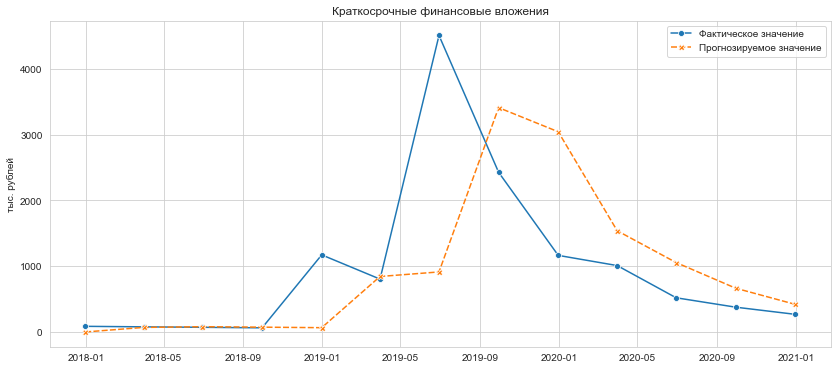

In [31]:
# Отобразим результаты прогнозирования краткосрочных финансовых вложений на графике
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')
sns.lineplot(data=[fso_data.f1_260[8:], f1_260_results], markers=True)
plt.legend(['Фактическое значение','Прогнозируемое значение'])
plt.title('Краткосрочные финансовые вложения'); plt.ylabel('тыс. рублей'); plt.show()

In [32]:
# Подставим наилучшие параметры для модели (3, 1, 0)x(3, 1, 0, 4),
# полученные автомотическим подбором и спрогнозируем денежные средства на 2021 г.
arima_f1_270 = SARIMAX(fso_data.f1_270, order=(3, 1, 0), seasonal_order=(3, 1, 0, 4)).fit()
f1_270_results = arima_f1_270.predict(start = 1, end = 24)
f1_270_pred = arima_f1_270.predict(start = 21, end = 24, typ="levels")

# Выведем результы прогноза денежных средств и их эквивалентов 
# ОАО "Компания А" на 2021 г. по кварталам
f1_270_pred

2021-03-31    29693.764715
2021-06-30    24242.968749
2021-09-30    25653.500481
2021-12-31    25604.921127
Freq: Q-DEC, Name: predicted_mean, dtype: float64

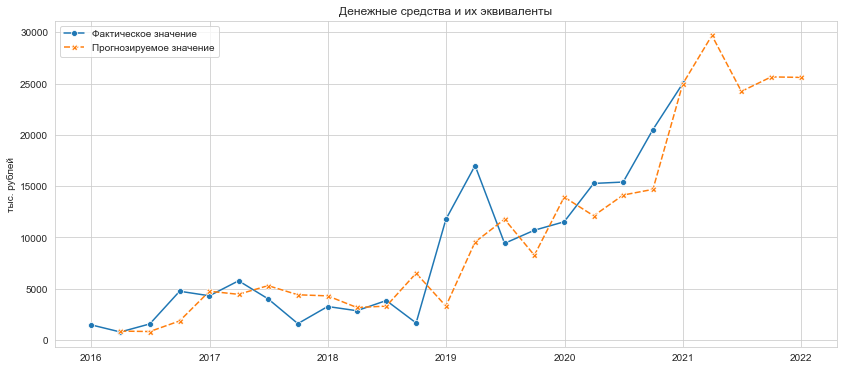

In [33]:
# Отобразим результаты прогнозирования денежных средств на графике
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')
sns.lineplot(data=[fso_data.f1_270, f1_270_results], markers=True)
plt.legend(['Фактическое значение','Прогнозируемое значение'])
plt.title('Денежные средства и их эквиваленты');
plt.ylabel('тыс. рублей'); plt.show()

In [34]:
# Получим значения долгосрочных активов ОАО Компания А на 31.12.2021 г.
f1_190 = round(f1_700_pred['2021-12-31']) - round(f1_290_pred['2021-12-31'])
print('Долгосрочные активы = {} тыс. руб.'.format(f1_190))

Долгосрочные активы = 101312 тыс. руб.


In [35]:
# Сведем значения прогноза на 2021 г. по "Итог баланса", "Долгосрочные активы",
# "Краткосрочные активы" "Краткосрочные финансовые вложения" и "Денежные средства" в одну таблицу 
f1_190_pred = f1_190 = f1_700_pred - f1_290_pred

pred2 = pd.DataFrame({"Итог баланса":[round(value) for value in f1_700_pred],
                      "Долгосрочные активы":[round(value) for value in f1_190_pred],
                      "Краткосрочные активы":[round(value) for value in f1_290_pred],
                      "Краткосрочные финансовые вложения":[round(value) for value in f1_260_pred],
                     "Денежные средства":[round(value) for value in f1_270_pred]},
                     index = ['1й квартал','2й квартал','3й квартал', '4й квартал'])

pred2.to_excel('pred2.xlsx'); pred2

,Итог баланса,Долгосрочные активы,Краткосрочные активы,Краткосрочные финансовые вложения,Денежные средства
1й квартал,183357,92627,90729,300,29694
2й квартал,190975,96742,94233,291,24243
3й квартал,194628,99532,95096,294,25654
4й квартал,201805,101312,100493,293,25605


In [36]:
# Оценим качество моделей посчитав среднюю абсолютную ошибку по прогнозируемым показателям,
# сравнив их с фактическим значением
mae_700 = f1_700_results[:20]; mae_290 = f1_290_results[:20]
mae_260 = f1_260_results[1:]; mae_270 = f1_270_results[:20]

arima_mae_f1 = pd.DataFrame({"Итог баланса": round(mean_absolute_error(fso_data.f1_700[1:], mae_700)),
                          "Краткосрочные активы": round(mean_absolute_error(fso_data.f1_290[1:], mae_290)),
                         "Краткосрочные финансовые вложения": round(mean_absolute_error(fso_data.f1_260[9:], mae_260)),
                           "Денежные средства": round(mean_absolute_error(fso_data.f1_270[1:], mae_270))},
                            index = ['MAE'])

arima_mae_f1.to_excel('arima_mae_f1.xlsx'); arima_mae_f1

,Итог баланса,Краткосрочные активы,Краткосрочные финансовые вложения,Денежные средства
MAE,2786,3598,762,2487


<p style='text-align: justify;'>Таким образом, по данным прогноза наша модель ошибается в среднем на 2 786 тыс. рублей при прогнозировании итога баланса, на 3 589 тыс. рублей при прогнозировании краткосрочных активов, на 762 тыс. рублей при прогнозировании краткосрочных финансовых вложений и на 2 487 тыс. рублей при прогнозировании денежных средств и их эквивалентов.</p>

<p style='text-align: justify;'>Поскольку у нас имеется практически функциональная зависимость между итогом баланса и собственным капиталом (корреляция составляет 99 %, т.е. сохраняется практически полная взаимозависимость), прогнозирование целесообразно проводить для собственного капитала и краткосрочных обязательств. Значение долгосрочных обязательств получим из следующего уравнения:</p>

**Долгосрочные обязательства = Итог баланса – Собственный капитал – Краткосрочные обязательства**

In [37]:
# Подставим наилучшие параметры для модели (2, 1, 2)x(1, 0, 2, 4),
# полученные автомотическим подбором и спрогнозируем cобственный капитал на 2021 г.
arima_f1_490 = SARIMAX(fso_data.f1_490, order=(2, 1, 2), seasonal_order=(1, 0, 2, 4)).fit()
f1_490_results = arima_f1_490.predict(start = 1, end = 24)
f1_490_pred = arima_f1_490.predict(start = 21, end = 24, typ="levels")

# Выведем результы прогноза cобственного капитала 
# ОАО "Компания А" на 2021 г. по кварталам
f1_490_pred

2021-03-31    158420.378092
2021-06-30    163249.165498
2021-09-30    168100.749739
2021-12-31    174885.974872
Freq: Q-DEC, Name: predicted_mean, dtype: float64

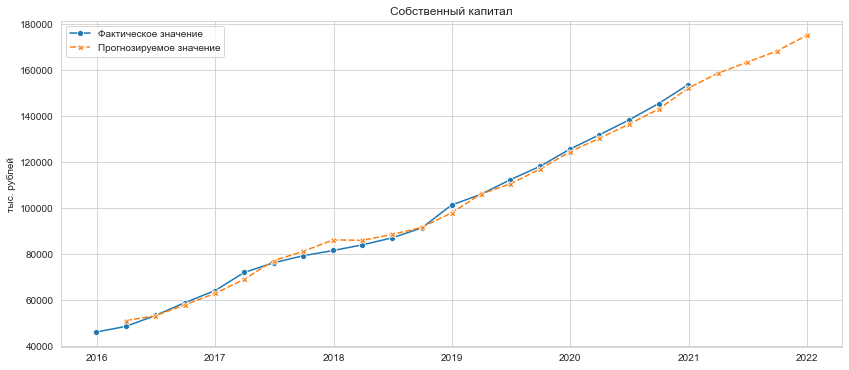

In [38]:
# Отобразим результаты прогнозирования cобственного капитала на графике
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')
sns.lineplot(data=[fso_data.f1_490, f1_490_results], markers=True)
plt.legend(['Фактическое значение','Прогнозируемое значение'])
plt.title('Собственный капитал'); plt.ylabel('тыс. рублей')
plt.savefig('arima_f1_490.png', dpi=600, bbox_inches='tight'); plt.show()

In [39]:
# Подставим наилучшие параметры для модели (0, 1, 0)x(0, 1, 1, 4),
# полученные автомотическим подбором и спрогнозируем краткосрочные обязательства на 2021 г.
arima_f1_690 = SARIMAX(fso_data.f1_690, order=(0, 1, 0), seasonal_order=(0, 1, 1, 4)).fit()
f1_690_results = arima_f1_690.predict(start = 1, end = 24)
f1_690_pred = arima_f1_690.predict(start = 21, end = 24, typ="levels")

# Выведем результы прогноза краткосрочных обязательств 
# ОАО "Компания А" на 2021 г. по кварталам 
f1_690_pred

2021-03-31    14567.908838
2021-06-30    15400.924401
2021-09-30    14582.412504
2021-12-31    15826.019968
Freq: Q-DEC, Name: predicted_mean, dtype: float64

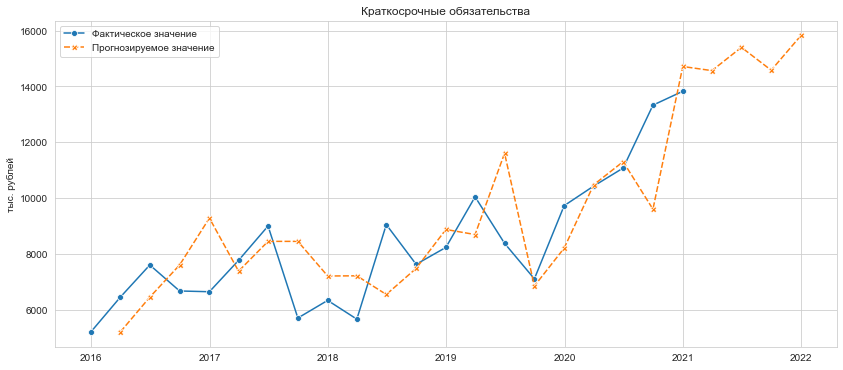

In [40]:
# Отобразим результаты прогнозирования краткосрочных обязательств на графике
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')
sns.lineplot(data=[fso_data.f1_690, f1_690_results], markers=True)
plt.legend(['Фактическое значение','Прогнозируемое значение'])
plt.title('Краткосрочные обязательства'); plt.ylabel('тыс. рублей')
plt.savefig('arima_f1_690.png', dpi=600, bbox_inches='tight'); plt.show()

In [41]:
# Получим значения долгосрочных обязательств на 31.12.2021 г.
f1_590 = round(f1_700_pred['2021-12-31']) - round(f1_490_pred['2021-12-31']) - round(f1_690_pred['2021-12-31'])
print('Долгосрочные обязательства = {} тыс. руб.'.format(f1_590))

Долгосрочные обязательства = 11093 тыс. руб.


In [42]:
# Сведем значения прогноза на 2021 г. по "Собственный капитал", "Долгосрочные обязательства"
# и "Краткосрочные обязательства" в одну таблицу
f1_590_pred = f1_700_pred - f1_490_pred - f1_690_pred

pred3 = pd.DataFrame({"Собственный капитал":[round(value) for value in f1_490_pred], 
                      "Долгосрочные обязательства":[round(value) for value in f1_590_pred],
                      "Краткосрочные обязательства":[round(value) for value in f1_690_pred]},
                     index = ['1й квартал','2й квартал','3й квартал', '4й квартал'])

pred3.to_excel('pred3.xlsx'); pred3

,Собственный капитал,Долгосрочные обязательства,Краткосрочные обязательства
1й квартал,158420,10368,14568
2й квартал,163249,12325,15401
3й квартал,168101,11944,14582
4й квартал,174886,11093,15826


In [43]:
# Оценим качество моделей посчитав среднюю абсолютную ошибку прогноза на 2020 г.
mae_490 = f1_490_results[:20]; mae_690 = f1_690_results[:20]

arima_mae3 = pd.DataFrame({"Собственный капитал": round(mean_absolute_error(fso_data.f1_490[1:], mae_490)),
                         "Краткосрочные обязательства": round(mean_absolute_error(fso_data.f1_690[1:],
                                                                                  mae_690))},
                          index = ['MAE'])
arima_mae3

,Собственный капитал,Краткосрочные обязательства
MAE,1690,1329


<p style='text-align: justify;'>Таким образом, по данным прогноза построенные модели ошибаются в среднем на 1 690 тыс. рублей при прогнозировании собственного капитала и на 1 329 тыс. рублей при прогнозировании долгосрочных обязательств.</p>

### 3 Отображение результатов прогноза бухгалтерской отчетности форм №1 и №2

In [44]:
# Определим названия отображаемых показателей
indexes1 = ['Выручка от реализации', 'Полная себестоимость', 'Прибыль от реализации', 'Прибыль до налогообложения', 
           'Чистая прибыль']

indexes2 = ['Итог баланса','Долгосрочные активы','Краткосрочные активы','Краткосрочные финансовые вложения', 
            'Денежные средства','Собственный капитал','Долгосрочные обязательства', 'Краткосрочные обязательства']

In [45]:
# Сформируем итоговую таблицу прогнозных показателей формы №2 "Отчет о прибылях и убытках" ОАО "Компания А"
df_f2 = {'Факт 2020 г.': [i.sum() for i in (test.f2_10, test.f2_full, test.f2_60, test.f2_150, test.f2_210)],
      'Прогноз на 2020 г.': [round(f2_10_results[16:20].sum()),
                             round(f2_10_results[16:20].sum() - f2_60_results[16:20].sum()), 
                             round(f2_60_results[16:20].sum()),
                             round(f2_150_results[16:20].sum()),
                             round(f2_150_results[16:20].sum() - ((f2_150_results[16:20].sum() * 0.18) - (f2_150_results[16:20].sum()*0.03)))],
      'Абсолютное отклонение' : [abs(test.f2_10.sum() - round(f2_10_results[16:20].sum())),
                                abs(test.f2_full.sum() - round(f2_10_results[16:20].sum() - f2_60_results[16:20].sum())),
                                abs(test.f2_60.sum() - round(f2_60_results[16:20].sum())),
                                abs(test.f2_150.sum() - round(f2_150_results[16:20].sum())),
                                abs(test.f2_210.sum() - round(f2_150_results[16:20].sum() - ((f2_150_results[16:20].sum() * 0.18) - (f2_150_results[16:20].sum()*0.03))))],
      'Прогноз на 2021 г.': [round(f2_10_pred.sum()), f2_full, round(f2_60_pred.sum()), round(f2_150_pred.sum()), f2_210]}


f2_table = pd.DataFrame(df_f2, index=indexes1)
f2_table.loc["Среднее абсолютное отклонение"] = ['-','-',round(pd.Series(df_f2['Абсолютное отклонение']).sum()/len(df_f2['Абсолютное отклонение'])), '-']
f2_table.to_excel('f2_table.xlsx')
f2_table

,Факт 2020 г.,Прогноз на 2020 г.,Абсолютное отклонение,Прогноз на 2021 г.
Выручка от реализации,234193,227319,6874,264491
Полная себестоимость,198939,192054,6885,226584
Прибыль от реализации,35254,35265,11,37907
Прибыль до налогообложения,33257,33394,137,34831
Чистая прибыль,27321,28384,1063,29606
Среднее абсолютное отклонение,-,-,2994,-


Таким образом, по данным прогноза на 2020 г. при прогнозировании статей отчета о прибылях и убытках средняя абсолютная ошибка составляет **2 994 тыс. рублей.**

In [46]:
# Сформируем итоговую таблицу прогнозных показателей формы №1 "Бухгалтерский баланс" ОАО "Компания А"
df_f1 = {'Факт на 31.12.20 г.': [test.f1_700[3:][0], test.f1_190[3:][0], test.f1_290[3:][0], test.f1_260[3:][0],
                             test.f1_270[3:][0], test.f1_490[3:][0], test.f1_590[3:][0], test.f1_690[3:][0]],
      'Прогноз на 31.12.20 г.': [round(f1_700_results[19]),
                                 round(f1_700_results[19]) - round(f1_290_results[19]),
                                 round(f1_290_results[19]),
                                 round(f1_260_results[12]),
                                 round(f1_270_results[19]),
                                 round(f1_490_results[19]),
                                 round(f1_700_results[19]) - round(f1_490_results[19]) - round(f1_690_results[19]),
                                 round(f1_690_results[19])],
      'Абсолютное отклонение' : [abs(test.f1_700[3:][0] - round(f1_700_results[19])),
                                     abs(test.f1_190[3:][0] - (round(f1_700_results[19]) - round(f1_290_results[19]))),
                                     abs(test.f1_290[3:][0] - round(f1_290_results[19])),
                                     abs(test.f1_260[3:][0] - round(f1_260_results[12])),
                                     abs(test.f1_270[3:][0] - round(f1_270_results[19])),
                                     abs(test.f1_490[3:][0] - round(f1_490_results[19])),
                                     abs(test.f1_590[3:][0] - (round(f1_700_results[19]) - round(f1_490_results[19]) - round(f1_690_results[19]))),
                                     abs(test.f1_690[3:][0] - round(f1_690_results[19]))],
      'Прогноз на 31.12.21 г.': [round(f1_700_pred[3:][0]),
                                    round(f1_700_pred[3:][0]) - round(f1_290_pred[3:][0]),
                                    round(f1_290_pred[3:][0]),
                                    round(f1_260_pred[3:][0]),
                                    round(f1_270_pred[3:][0]),
                                    round(f1_490_pred[3:][0]),
                                    round(f1_700_pred[3:][0]) - round(f1_490_pred[3:][0]) - round(f1_690_pred[3:][0]),
                                    round(f1_690_pred[3:][0])]}


f1_table = pd.DataFrame(df_f1, index=indexes2)
f1_table.loc["Среднее абсолютное отклонение"] = ['-','-',round(pd.Series(df_f1['Абсолютное отклонение']).sum()/len(df_f1['Абсолютное отклонение'])), '-']
f1_table.to_excel('f1_table.xlsx')
f1_table

,Факт на 31.12.20 г.,Прогноз на 31.12.20 г.,Абсолютное отклонение,Прогноз на 31.12.21 г.
Итог баланса,179808,177921,1887,201805
Долгосрочные активы,92922,94045,1123,101312
Краткосрочные активы,86886,83876,3010,100493
Краткосрочные финансовые вложения,268,419,151,293
Денежные средства,25014,24977,37,25605
Собственный капитал,153604,152081,1523,174886
Долгосрочные обязательства,12375,11124,1251,11093
Краткосрочные обязательства,13829,14716,887,15826
Среднее абсолютное отклонение,-,-,1234,-


Таким образом, по данным прогноза на 31.12.2020 г. при прогнозировании статей бухгалтерского средняя абсолютная ошибка составляет **1 234 тыс. рублей.**